In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns

from scripts.analysis import normalize
from scripts.data_processing import process_trials_from_df

In [2]:
# set1 SAME players condition actual past participant lies

with open('data/as31_lies.json', 'r', encoding='utf-8') as f:
    as31_lies = json.load(f)
    
with open('data/bs02_lies.json', 'r', encoding='utf-8') as f:
    bs02_lies = json.load(f)

In [3]:
# set1 SAME players condition block trials: p2b_s11, p2a_s31, p2b_s02

with open('./trial_setups/p2b_s11.json', 'r') as f:
    bs11 = json.load(f)
    bs11 = pd.DataFrame.from_dict(bs11)
    bs11 = process_trials_from_df(bs11, 7)

with open('./trial_setups/p2b_s02.json', 'r') as f:
    bs02 = json.load(f)
    bs02 = pd.DataFrame.from_dict(bs02)
    bs02 = process_trials_from_df(bs02, 7)
    
with open('./trial_setups/p2a_s31.json', 'r') as f:
    as31 = json.load(f)
    as31 = pd.DataFrame.from_dict(as31)
    as31 = process_trials_from_df(as31, 7)

In [4]:
as31['pp_lied'] = as31_lies

In [5]:
bs02['pp_lied'] = bs02_lies

In [6]:
bs11['pp_lied'] = 0

In [7]:
# load normalized reverse-coded honesty ratings, i.e. normalized suspicion ratings

with open('final_pilot_sameplayer_normalized_suspicion_ratings.json', 'r') as f:
    ratings = json.load(f)

In [8]:
uuids = ratings.keys()

In [9]:
# load same player condition block order assignment labels

with open('same_conditions.json', 'r') as f:
    conditions = json.load(f)

In [10]:
def get_same_cond_trials(uuid, conditions):
#     print(uuid)

    if conditions[uuid] == "11":
        trials = pd.concat([bs11, as31, bs02]).reset_index()
    elif conditions[uuid] == "12":
        trials = pd.concat([bs11, bs02, as31]).reset_index()
    elif conditions[uuid] == "21":
        trials = pd.concat([as31, bs11, bs02]).reset_index()
    elif conditions[uuid] == "22":
        trials = pd.concat([as31, bs02, bs11]).reset_index()
    elif conditions[uuid] == "31":
        trials = pd.concat([bs02, bs11, as31]).reset_index()
    elif conditions[uuid] == "32":
        trials = pd.concat([bs02, as31, bs11]).reset_index()
    else:
        print('no applicable trials associated with subject condition found')
    
    return trials

In [134]:
with open('same_when_lied.json', 'r') as f:
    when_lied = json.load(f)
    
with open('same_picked_col.json', 'r') as f:
    col_pick = json.load(f)
    
with open('same_reported_col.json', 'r') as f:
    reported_col = json.load(f)
    
with open('same_RT_honesty_rating.json', 'r') as f:
    RT_hr = json.load(f)

with open('same_win_lose_tie.json', 'r') as f:
    winlose = json.load(f)

In [12]:
from scipy.stats import pearsonr, spearmanr, zscore, mannwhitneyu, wilcoxon

In [335]:
agg_f1 = []
agg_df = []

subject = []
t_conds = []
n_hrs = []
s_ev = []
us_ev = []

hits = []
false_alarm = []

e_hits = []
e_false_alarm = []

for i, uuid in enumerate(uuids):
    trials = get_same_cond_trials(uuid, conditions)
    trials['trial_cond'] = trials['n_red'] * trials['outcome']

    rating = [ratings[uuid][k] for k in ratings[uuid].keys()]
    
    subject.extend([i] * len(trials))
    t_conds.extend(trials['trial_cond'].values)
    n_hrs.extend(rating)
    
    #todo: pass trials with honesty rating 0.5 for lie detection accuracy
    detected_deception = [1 if float(r) > 0.5 else 0 for r in rating]
#     print(pearsonr(trials['trial_cond'], rating))
    
    lies = when_lied[uuid]

    s_ev.extend(trials['normed_signed_e_v'].values)
    us_ev.extend(trials['normed_unsigned_e_v'].values)
    
    df = pd.DataFrame({'n_red': trials['n_red'], 
                    'outcome': trials['outcome'],
                       't_cond': trials['trial_cond'], 
                       'signed_ev': trials['normed_signed_e_v'], 
                       'unsigned_ev': trials['normed_unsigned_e_v'], 
                       'n_consec_col': trials['n_consec_colour'],
                       'signed_n_col': trials['n_consec_colour'] * trials['outcome'],
                       'hr': rating, 
                       'pp_lied': trials['pp_lied'], 'lied': lies,
                        'reported_col': reported_col[uuid],
                       'picked_col': col_pick[uuid], 
                       'RT_hr': RT_hr[uuid],
                       'win_lose_tie': winlose[uuid],
                      'subject': i,
                      'nred_transition': trials['n_red'].diff().values,
                      'tcond_transition': trials['trial_cond'].diff().values})
    
    df['nred_transition'][0] = 0
    df['tcond_transition'][0] = 0
    
    agg_df.append(df)
    
    tp = [1 if (x==1) & (y==1) else 0 for x, y in zip(trials['pp_lied'], detected_deception)]
    tp = sum(tp)
    
    fp = [1 if (x==0) & (y==1) else 0 for x, y in zip(trials['pp_lied'], detected_deception)]
    fp = sum(fp)
    
    tn = [1 if (x==0) & (y==0) else 0 for x, y in zip(trials['pp_lied'], detected_deception)]
    tn = sum(tn)
    
    fn = [1 if (x==1) & (y==0) else 0 for x, y in zip(trials['pp_lied'], detected_deception)]
    fn = sum(fn)
    
    hits.append(tp)
    false_alarm.append(fp)
    
    accuracy = (tp + tn)/len(trials)
    
    f1 = tp/(tp+0.5*(fp+fn))
    agg_f1.append(f1)
    
    specificity = tn/(fp+tn)
    
#     print("hits", tp)
#     print("misses", fn)
#     print("false alarm", fp)
#     print(specificity)
#    print(accuracy)
#     precision = tp/(tp+fp)
#     recall = tp/(tp+fn)
#     print(2*(precision*recall)/(precision+recall))
#     print(tp/(tp+fp)) # "lie detection precision", 
#     print(tp/(tp+fn)) # "lie detection recall", 
    
    df_exclude05 = df[df['hr'] != 0.5]
    
    detected_deception_e = [1 if v > 0.5 else 0 for v in df_exclude05['hr']]
    
    e_tp = [1 if (x==1) & (y==1) else 0 for x, y in zip(df_exclude05['pp_lied'].values, detected_deception)]
    e_tp = sum(e_tp)
    
    e_fp = [1 if (x==0) & (y==1) else 0 for x, y in zip(df_exclude05['pp_lied'].values, detected_deception)]
    e_fp = sum(e_fp)
    
    e_tn = [1 if (x==0) & (y==0) else 0 for x, y in zip(df_exclude05['pp_lied'].values, detected_deception)]
    e_tn = sum(e_tn)
    
    e_fn = [1 if (x==1) & (y==0) else 0 for x, y in zip(df_exclude05['pp_lied'].values, detected_deception)]
    e_fn = sum(e_fn)
    
    e_hits.append(e_tp)
    e_false_alarm.append(e_fp)
    
    if e_tp == 0:
        e_precision = 0
        e_recall = 0
    else:
        e_precision = e_tp/(e_tp+e_fp)
        e_recall = e_tp/(e_tp+e_fn)
    print("precision", e_precision)
    print("recall", e_recall)

precision 0
recall 0
precision 0
recall 0
precision 0.3333333333333333
recall 0.05263157894736842
precision 0.18181818181818182
recall 0.13333333333333333
precision 0.30434782608695654
recall 0.4666666666666667
precision 0.26666666666666666
recall 0.47058823529411764
precision 0
recall 0
precision 0.6666666666666666
recall 0.42105263157894735
precision 0
recall 0
precision 0.2777777777777778
recall 0.3333333333333333


<ipython-input-335-bb04da212b10>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['nred_transition'][0] = 0
<ipython-input-335-bb04da212b10>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tcond_transition'][0] = 0
<ipython-input-335-bb04da212b10>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['nred_transition'][0] = 0
<ipython-input-335-bb04da212b10>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [336]:
list(dfs)

['n_red',
 'outcome',
 't_cond',
 'signed_ev',
 'unsigned_ev',
 'n_consec_col',
 'signed_n_col',
 'hr',
 'pp_lied',
 'lied',
 'reported_col',
 'picked_col',
 'RT_hr',
 'win_lose_tie',
 'subject',
 'nred_transition',
 'tcond_transition',
 'outcome_same_as_pick']

In [171]:
tmp = dfs[['subject', 'signed_ev', 'hr']]

In [173]:
# tmp.reset_index().to_feather('same_long_ev_normed_hr.feather')

In [174]:
import statsmodels.formula.api as smf

In [175]:
md = smf.mixedlm("hr ~ signed_ev", tmp, groups=tmp["subject"], re_formula="~signed_ev")
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    hr     
No. Observations:     900        Method:                REML   
No. Groups:           10         Scale:                 0.0482 
Min. group size:      90         Log-Likelihood:        55.2990
Max. group size:      90         Converged:             Yes    
Mean group size:      90.0                                     
---------------------------------------------------------------
                      Coef.  Std.Err.   z   P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept              0.096    0.061 1.586 0.113 -0.023  0.215
signed_ev              0.447    0.079 5.665 0.000  0.292  0.602
Group Var              0.034    0.080                          
Group x signed_ev Cov -0.031    0.090                          
signed_ev Var          0.057    0.134                          



<AxesSubplot:xlabel='ev', ylabel='normed_suspicion'>

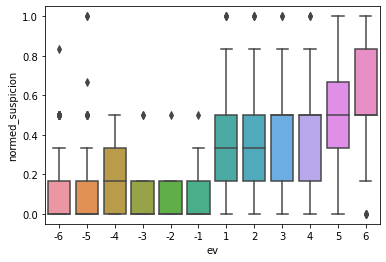

In [101]:
sns.boxplot(data=df, x='ev', y='normed_suspicion')

<AxesSubplot:xlabel='ev', ylabel='s_ev'>

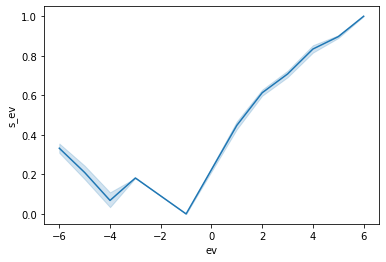

In [104]:
sns.lineplot(data=df, x='ev', y='s_ev')

In [50]:
pd.crosstab(as31['n_red'], as31['pp_lied'])

pp_lied,0,1
n_red,,
1,3,0
2,6,0
3,4,0
4,3,1
5,5,1
6,5,2


In [58]:
pd.crosstab(as31['n_red'], as31['outcome'])

outcome,-1,1
n_red,,
1,0,3
2,0,6
3,0,4
4,3,1
5,2,4
6,4,3


<AxesSubplot:xlabel='n_red', ylabel='Count'>

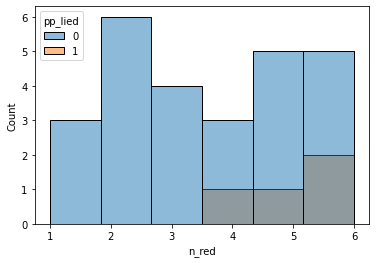

In [51]:
sns.histplot(data=as31, x='n_red', hue='pp_lied')

In [54]:
pd.crosstab(bs02['n_red'], bs02['pp_lied'])

pp_lied,0,1
n_red,,
1,4,1
2,2,0
3,2,0
4,0,2
5,5,5
6,2,7


In [55]:
pd.crosstab(bs02['n_red'], bs02['outcome'])

outcome,-1,1
n_red,,
1,0,5
2,0,2
3,0,2
4,0,2
5,2,8
6,2,7


<AxesSubplot:xlabel='n_red', ylabel='Count'>

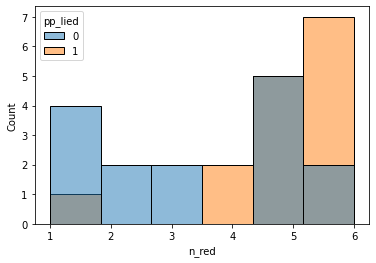

In [52]:
sns.histplot(data=bs02, x='n_red', hue='pp_lied')

<AxesSubplot:xlabel='n_red', ylabel='Count'>

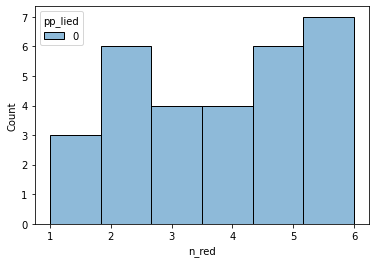

In [53]:
sns.histplot(data=bs11, x='n_red', hue='pp_lied')

In [57]:
pd.crosstab(bs11['n_red'], bs11['outcome'])

outcome,-1,1
n_red,,
1,1,2
2,1,5
3,1,3
4,1,3
5,4,2
6,7,0


In [59]:
import matplotlib
import matplotlib.pyplot as plt

## Fit GLM per individual, suspicion <- signed EV without update

In [113]:
import statsmodels.api as sm

i_coef = []

for i, df in enumerate(agg_df):
    print("SUBJECT", i)
    df['subject'] = i
    df['const'] = 1
    model = sm.GLM(df['hr'], df[['const', 'signed_ev']])
    result = model.fit()
    print(result.summary())
    i_coef.append(result.params)

SUBJECT 0
                 Generalized Linear Model Regression Results                  
Dep. Variable:                     hr   No. Observations:                   90
Model:                            GLM   Df Residuals:                       88
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                        0.055269
Method:                          IRLS   Log-Likelihood:                 3.6062
Date:                Sat, 18 Sep 2021   Deviance:                       4.8637
Time:                        17:51:02   Pearson chi2:                     4.86
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0825      0.054      1.53

In [114]:
intercept = [i['const'] for i in i_coef]
s_ev_coef = [i['signed_ev'] for i in i_coef]

Text(0.5, 1.0, 'SAME GLM coefficient, signed EV')

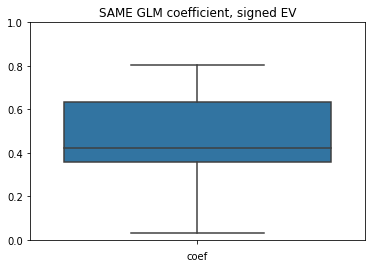

In [115]:
p = sns.boxplot(y=s_ev_coef)
p.set(xlabel="coef", ylim=(0,1))
p.set_title("SAME GLM coefficient, signed EV")

In [308]:
dfs = pd.concat(agg_df)

In [314]:
sns.set()
sns.set_style("whitegrid")

[Text(0.5, 0, "# red cards * other player's card colour"),
 Text(0, 0.5, 'suspicion rating')]

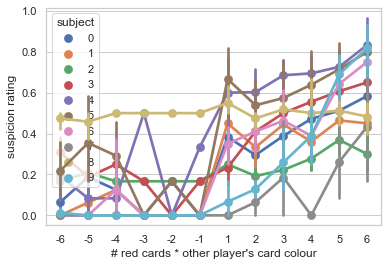

In [318]:
p = sns.pointplot(data=dfs, x="t_cond", y="hr", hue="subject")
p.set(xlabel="# red cards * other player's card colour", ylabel="suspicion rating")
# p.set_xticklabels(xticks)

<AxesSubplot:xlabel='t_cond', ylabel='signed_ev'>

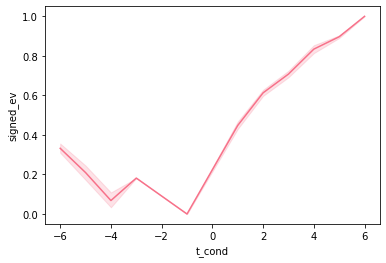

In [200]:
sns.lineplot(data=dfs, x='t_cond', y='signed_ev')

C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


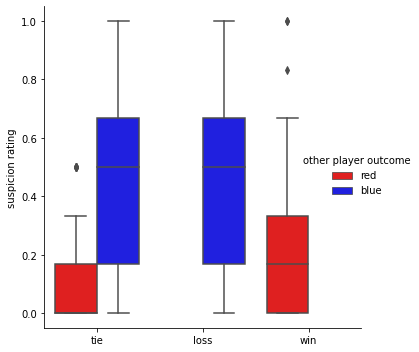

In [217]:
col_dict = {-1: "r", 1: "b"}
p = sns.factorplot(x="win_lose_tie", hue="outcome", y="hr", data=dfs, kind="box", palette=col_dict)

p.set(xlabel="", ylabel="suspicion rating")

p._legend.set_title("other player outcome")

new_labels = ['red', 'blue']
for t, l in zip(p._legend.texts, new_labels):
    t.set_text(l)

C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


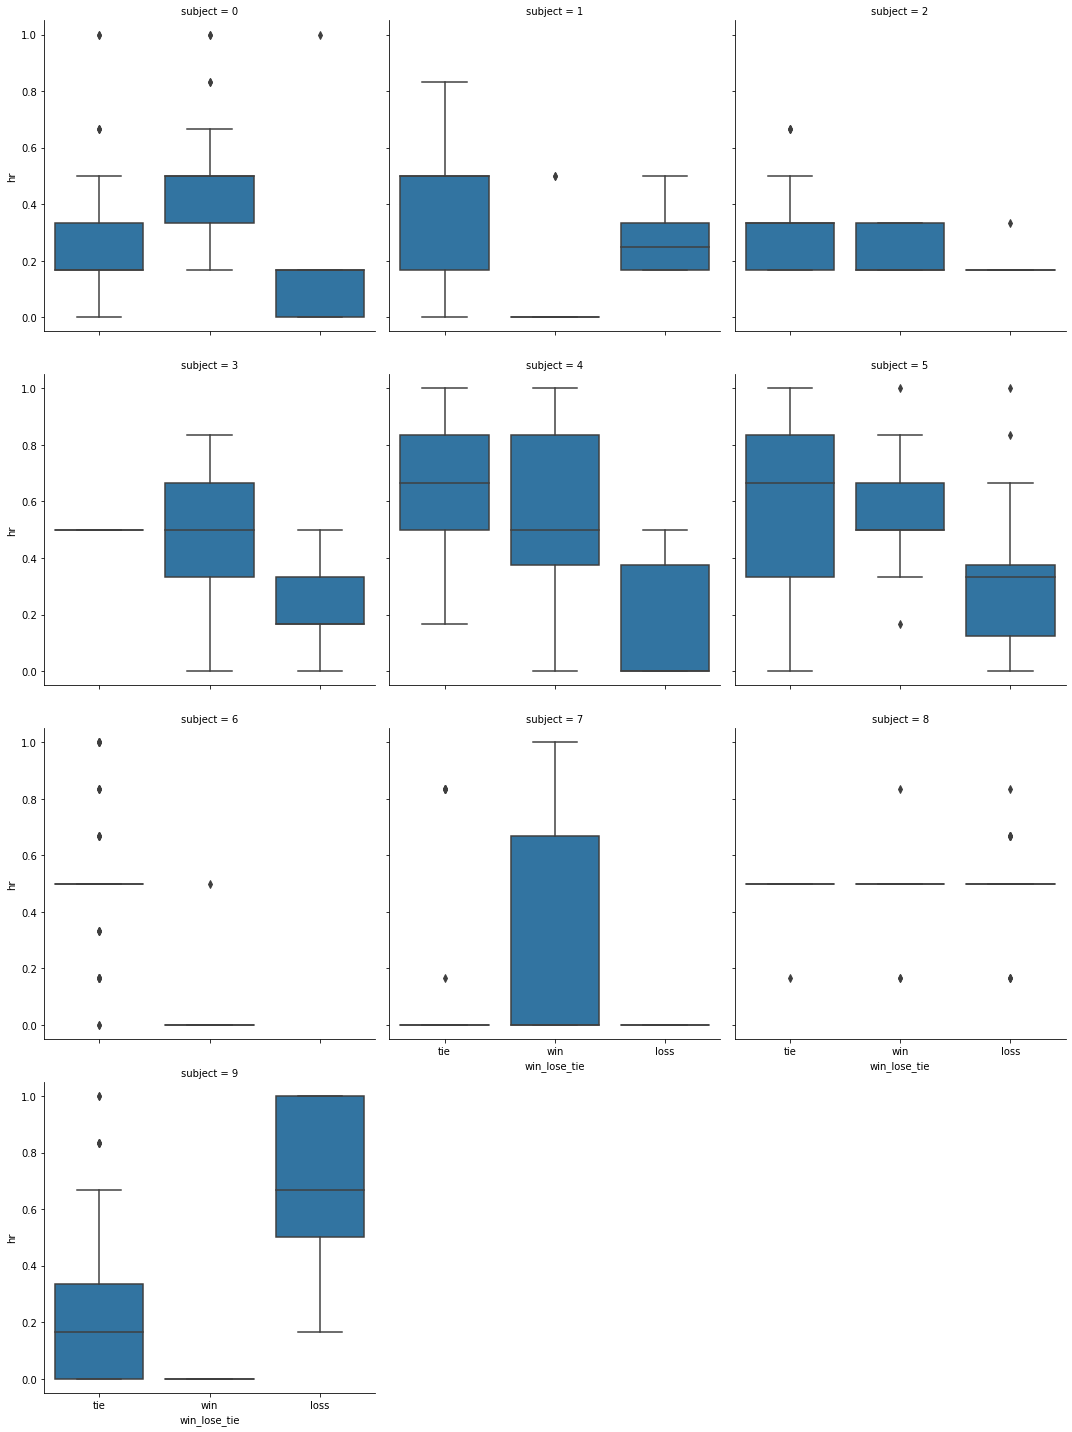

In [143]:
g = sns.FacetGrid(dfs, col="subject", col_wrap=3, height=5)
g.map(sns.boxplot, "win_lose_tie", "hr", hue="outcome")

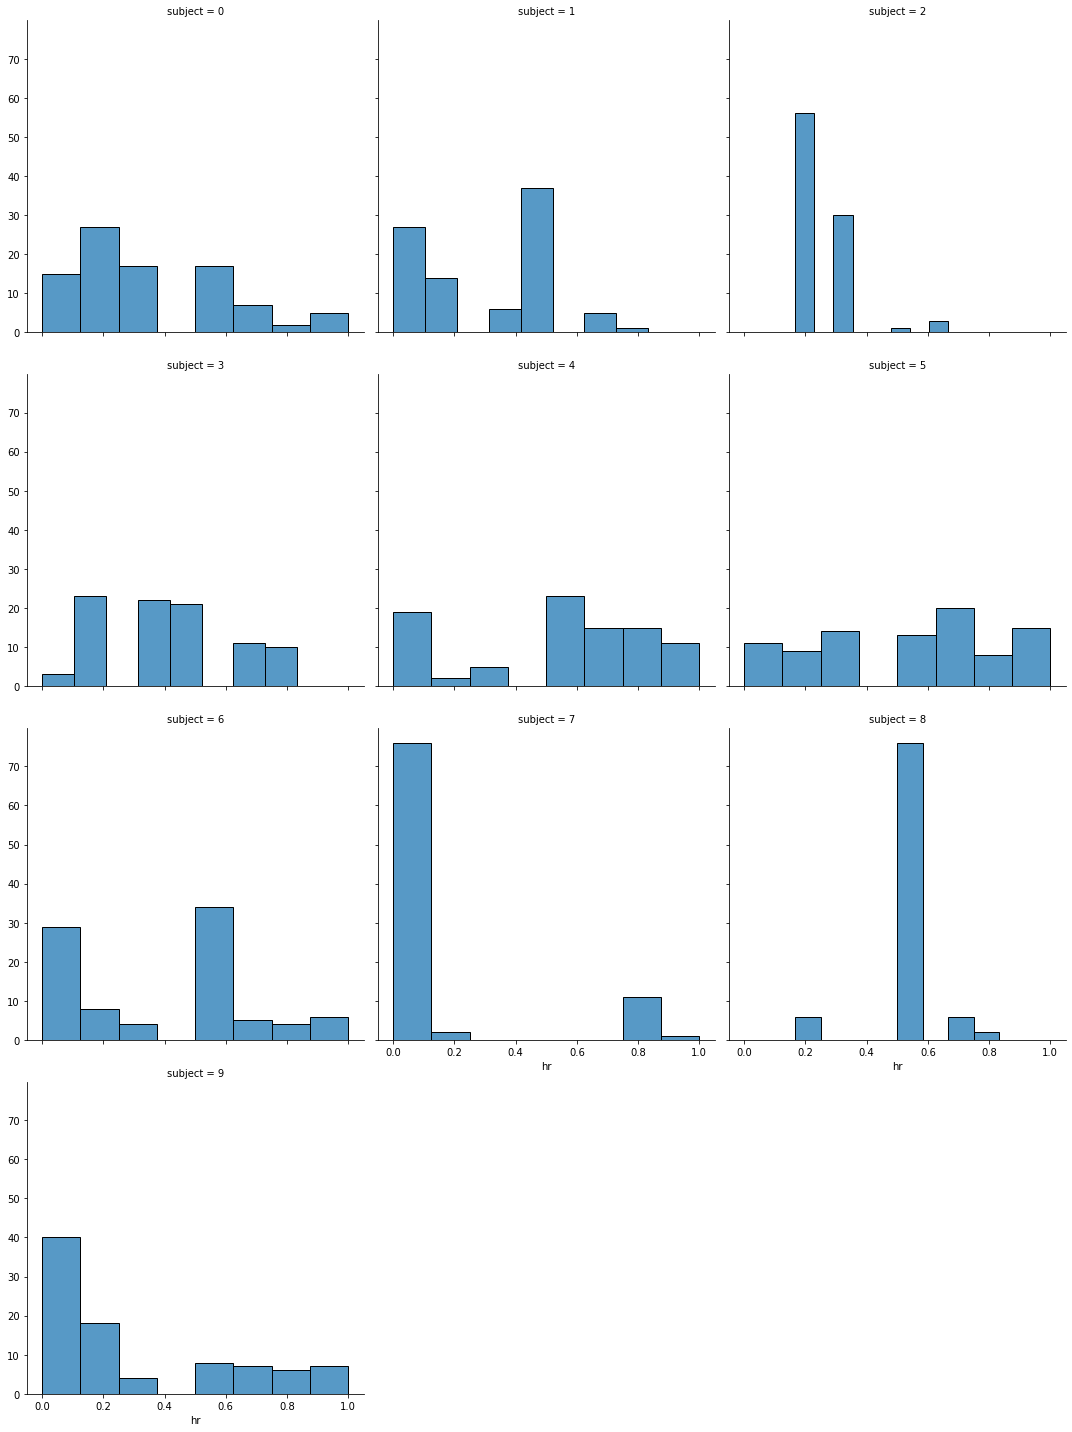

In [133]:
g = sns.FacetGrid(dfs, col="subject", col_wrap=3, height=5)
g.map(sns.histplot, "hr")

C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


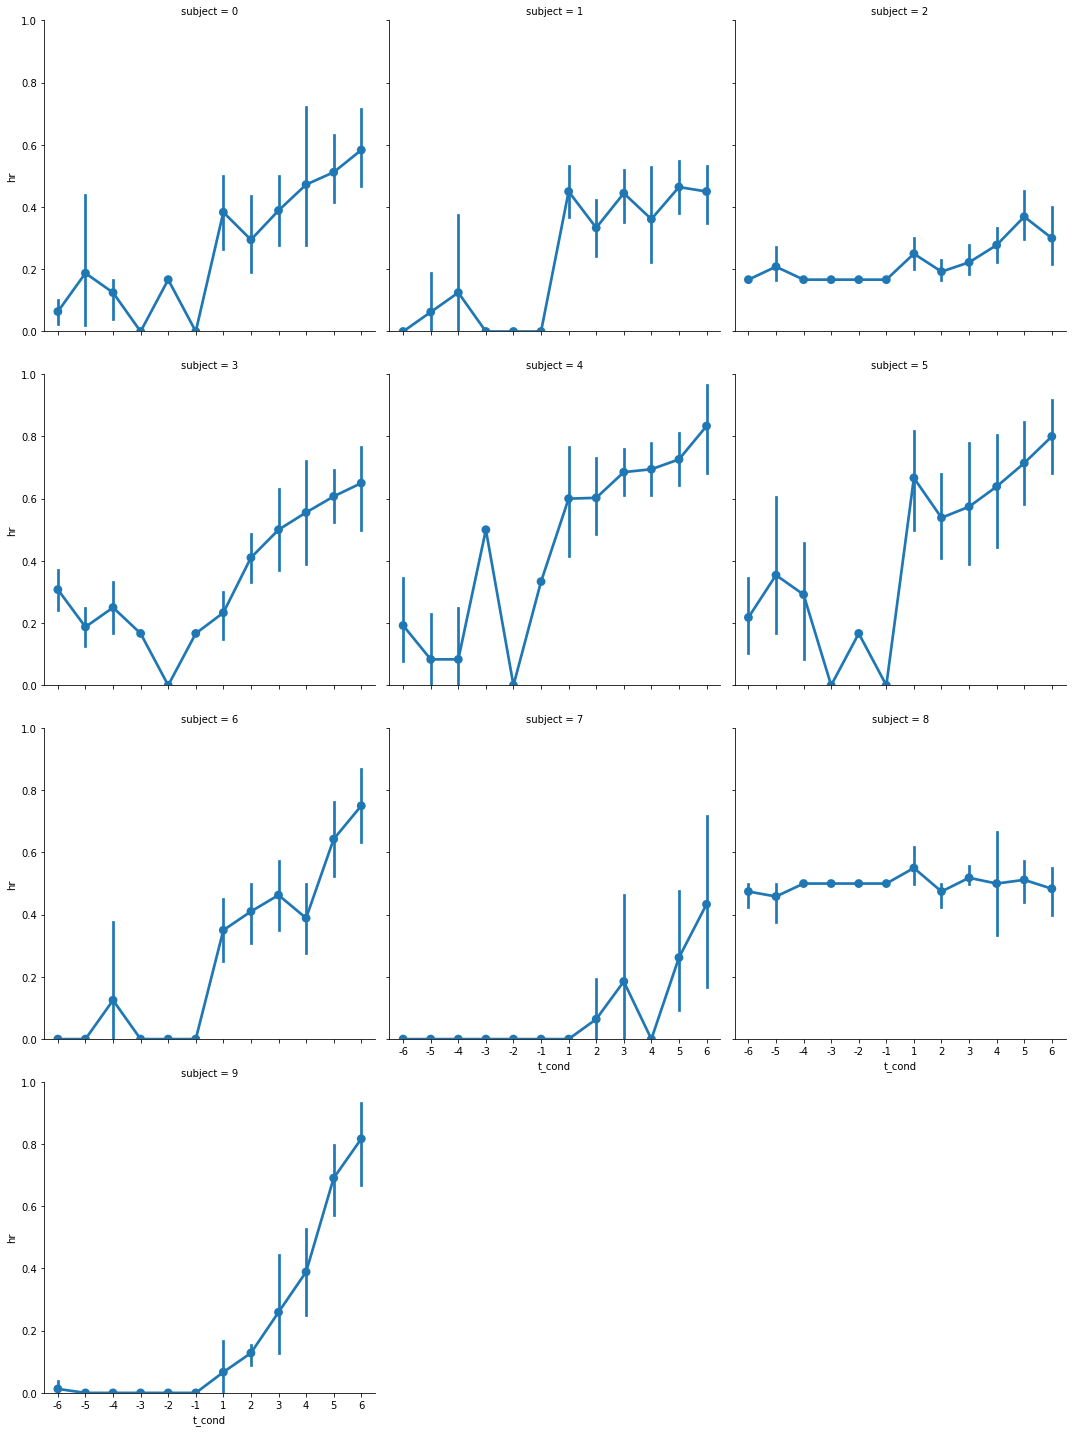

In [129]:
g = sns.FacetGrid(dfs, col="subject", col_wrap=3, height=5, ylim=(0, 1))
g.map(sns.pointplot, "t_cond", "hr")

In [33]:
from statistics import variance

for i in range(len(uuids)):
    print(variance(agg_df[i]['hr']))

0.07178526841210987
0.0575530586760799
0.013209182961466222
0.05258704396881953
0.1112359550544819
0.10398113469258982
0.09607435150371757
0.08392634206657927
0.011846303230850324
0.11548064918639202


[Text(0.5, 0, '# red cards x outcome colour value'), (-7.0, 7.0)]

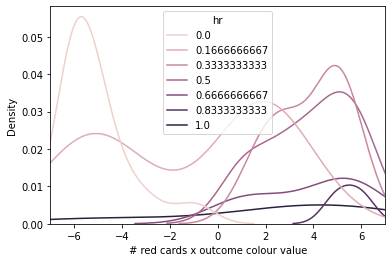

In [114]:
# plot normalized suspicion for each level of expectation violation    
p = sns.kdeplot(data=agg_df[0], x='trial_cond', hue='hr')
p.set(xlabel="# red cards x outcome colour value", xlim=(-7,7))
# p.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Subject 7')

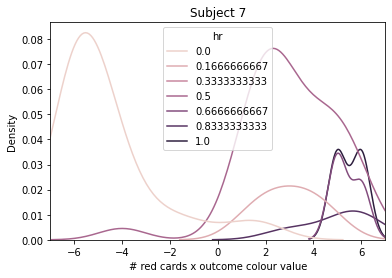

In [120]:
# plot normalized suspicion for each level of expectation violation    
p = sns.kdeplot(data=agg_df[6], x='trial_cond', hue='hr')
p.set(xlabel="# red cards x outcome colour value", xlim=(-7,7))
# p.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
p.set_title("Subject 7")

Text(0.5, 1.0, 'Subject 9')

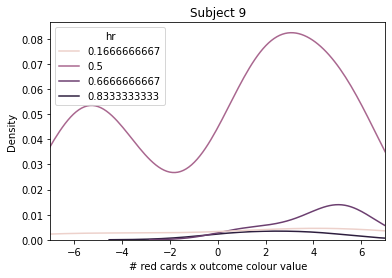

In [277]:
# plot normalized suspicion for each level of expectation violation    
p = sns.kdeplot(data=agg_df[8], x='t_cond', hue='hr')
p.set(xlabel="# red cards x outcome colour value", xlim=(-7,7))
# p.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
p.set_title("Subject 9")

In [17]:
df2 = df

In [28]:
# df2 = df[df['subject'] != 8]
df2 = df[df['subject'] != 2]

In [29]:
md = smf.mixedlm("normed_suspicion ~ ev", df2, groups=df2["subject"], re_formula="~ev")
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: normed_suspicion
No. Observations: 810     Method:             REML            
No. Groups:       9       Scale:              0.0437          
Min. group size:  90      Log-Likelihood:     85.7790         
Max. group size:  90      Converged:          Yes             
Mean group size:  90.0                                        
---------------------------------------------------------------
                 Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------------
Intercept         0.338     0.045  7.474  0.000   0.249   0.426
ev                0.040     0.006  6.504  0.000   0.028   0.052
Group Var         0.018     0.044                              
Group x ev Cov   -0.000     0.004                              
ev Var            0.000     0.001                              



C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [22]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    likev = mdf.profile_re(0, 're', dist_low=0, dist_high=0.1)

In [26]:
from statsmodels.tools.sm_exceptions import ConvergenceWarning

import matplotlib.pyplot as plt

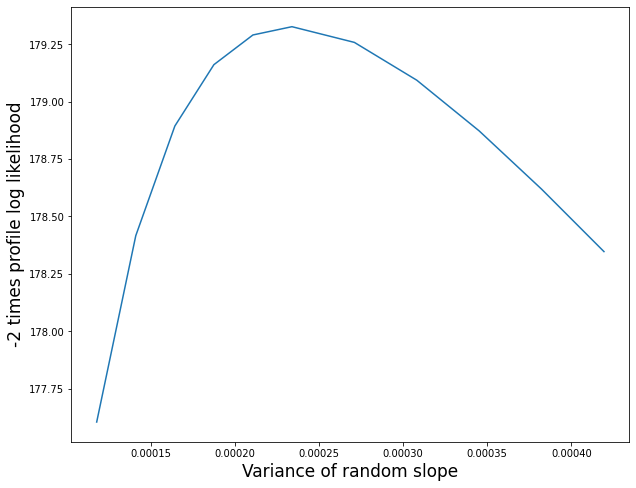

In [27]:
re = mdf.cov_re.iloc[1, 1]
with warnings.catch_warnings():
    # Parameter is often on the boundary
    warnings.simplefilter("ignore", ConvergenceWarning)
    likev = mdf.profile_re(1, 're', dist_low=.5*re, dist_high=0.8*re)

plt.figure(figsize=(10, 8))
plt.plot(likev[:,0], 2*likev[:,1])
plt.xlabel("Variance of random slope", size=17)
lbl = plt.ylabel("-2 times profile log likelihood", size=17)

In [309]:
z_false_alarm = zscore(false_alarm)

In [310]:
z_hits = zscore(hits)

In [311]:
d_prime = np.subtract(z_hits, z_false_alarm)

In [338]:
z_e_false_alarm = zscore(e_false_alarm)
z_e_hits = zscore(e_hits)
e_dprime = np.subtract(z_e_hits, z_e_false_alarm)

In [340]:
spearmanr(e_dprime, s_ev_alpha)

SpearmanrResult(correlation=-0.5151515151515151, pvalue=0.12755286970323426)

In [341]:
spearmanr(e_dprime, s_ev_prior)

SpearmanrResult(correlation=0.09203146787097732, pvalue=0.8003776447383397)

<AxesSubplot:>

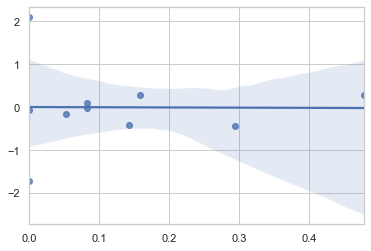

In [342]:
sns.regplot(x=s_ev_prior, y=e_dprime)

<AxesSubplot:>

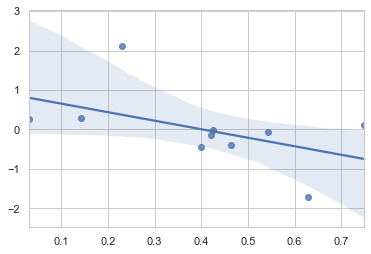

In [343]:
sns.regplot(x=s_ev_alpha, y=e_dprime)

In [275]:
# excluding 0.5 as lie detected

list(zip(z_hits, z_false_alarm))

[(-0.4581621289927276, -0.2166799219611496),
 (-1.2217656773139403, -0.6728481787214644),
 (-1.4126665643942433, -0.9009323071016219),
 (0.6872431934890912, -0.10263785777107089),
 (1.0690449676496976, 1.950119297650346),
 (1.4508467418103037, 1.950119297650346),
 (0.49634230640878807, -0.6728481787214644),
 (-0.26726124191242445, -0.5588061145313857),
 (-1.2217656773139403, -0.444764050341307),
 (0.8781440805693944, -0.33072198615122833)]

In [265]:
# including 0.5 as lie detected

list(zip(z_hits, z_false_alarm))

[(-0.4824752523663835, -0.40901359304656315),
 (0.07422696190252062, 0.06905424298188732),
 (-2.3381492999293974, -1.3120306166558584),
 (0.44536177141512334, -0.09030170236092949),
 (0.8164965809277261, 0.9720712665911827),
 (0.8164965809277261, 0.5471220790103378),
 (0.8164965809277261, 0.17529153987709856),
 (-1.224744871391589, -1.2057933197606472),
 (0.44536177141512334, 2.140681532438506),
 (0.6309291761714247, -0.8870814290750136)]

In [81]:
for i in range(len(uuids)):
    print(agg_df[i].pivot_table(columns=["t_cond", "pp_lied"], values="hr"))

t_cond         -6      -5     -4   -3        -2   -1        1              2  \
pp_lied         0       0      0    0         0    0        0    1         0   
hr       0.064103  0.1875  0.125  0.0  0.166667  0.0  0.37037  0.5  0.294872   

t_cond          3         4                   5              6            
pp_lied         0         0         1         0         1    0         1  
hr       0.388889  0.388889  0.555556  0.541667  0.472222  0.5  0.592593  
t_cond    -6      -5     -4   -3   -2   -1         1              2         3  \
pp_lied    0       0      0    0    0    0         0    1         0         0   
hr       0.0  0.0625  0.125  0.0  0.0  0.0  0.444444  0.5  0.333333  0.444444   

t_cond          4                   5              6            
pp_lied         0         1         0         1    0         1  
hr       0.277778  0.444444  0.458333  0.472222  0.5  0.444444  
t_cond         -6        -5        -4        -3        -2        -1         1  \
pp_lied       

In [141]:
tmp = agg_df[1].pivot_table(index=agg_df[1].index, columns="lied", values="RT_hr")

In [274]:
i=1
agg_df[i][agg_df[i]['lied'] == 1]['RT_hr'].mean()

8980.275

In [40]:
from collections import Counter

In [194]:
for i in range(len(uuids)):
#     print("subject", i)
    tmp = agg_df[i].pivot_table(index=agg_df[i].index, columns="lied", values="RT_hr")
    lie = tmp[[1]].to_numpy().flatten()
    no_lie = tmp[[0]].to_numpy().flatten()
    
    lie = [v for v in lie if not np.isnan(v)]
    no_lie = [v for v in no_lie if not np.isnan(v)]

#     print(tmp[[0]].mean(), tmp[[1]].mean())
    print(mannwhitneyu(lie, no_lie))
#     print(tmp[[0]].values)

MannwhitneyuResult(statistic=12.0, pvalue=0.10901811354129248)
MannwhitneyuResult(statistic=929.5, pvalue=0.2848766253229316)
MannwhitneyuResult(statistic=798.5, pvalue=0.04796291426195817)
MannwhitneyuResult(statistic=914.5, pvalue=0.22022846750544955)
MannwhitneyuResult(statistic=510.0, pvalue=0.1948654668904417)
MannwhitneyuResult(statistic=744.0, pvalue=0.404964412478957)
MannwhitneyuResult(statistic=844.5, pvalue=0.14777897586968536)
MannwhitneyuResult(statistic=122.0, pvalue=0.01809827810261586)
MannwhitneyuResult(statistic=843.0, pvalue=0.1449474127787474)
MannwhitneyuResult(statistic=595.0, pvalue=0.15524146083520923)


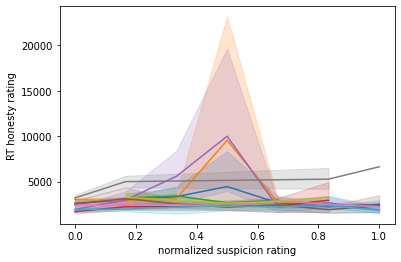

In [284]:
# plot RTs for various EV levels
for i in range(len(uuids)):
    p = sns.lineplot(data=agg_df[i], x='hr', y='RT_hr')
    p.set(xlabel="normalized suspicion rating", ylabel="RT honesty rating")

In [266]:
agg_df[0]

,n_red,t_cond,hr,pp_lied,lied,reported_col,picked_col,RT_hr
0,6,-6,0.000000,0,0,-1,-1,3284
1,6,-6,0.000000,0,0,-1,-1,3309
2,2,2,0.166667,0,0,1,1,2851
3,3,3,0.500000,0,0,-1,-1,34148
4,1,1,0.166667,0,0,1,1,4211
...,...,...,...,...,...,...,...,...
85,1,1,0.666667,0,0,1,1,2223
86,5,-5,1.000000,0,0,1,1,3372
87,2,2,1.000000,0,0,1,1,2445
88,6,6,1.000000,1,0,-1,-1,2195


In [240]:
spearmanr(d_prime, [3, 3, 5, 3, 4, 4,2, 0, 4,4])

SpearmanrResult(correlation=-0.43713808458768466, pvalue=0.20649075721807408)

In [190]:
i=3
pd.crosstab(index=agg_df[i]['picked_col'], columns=agg_df[i]['reported_col'])

reported_col,-1,1
picked_col,,
-1,2,43
1,0,45


In [199]:
agg_df[9].groupby(['n_red', 'picked_col', 'reported_col']).size()

n_red  picked_col  reported_col
1      -1           1               1
        1           1              10
2      -1           1               4
        1           1              10
3      -1           1               4
        1           1               6
4      -1          -1               4
                    1               4
        1           1               2
5      -1          -1              10
                    1               5
        1           1               7
6      -1          -1              20
                    1               2
        1           1               1
dtype: int64

In [226]:
for i in range(len(uuids)):
    print(spearmanr(agg_df[i]['hr'].diff()[1:-1], agg_df[1]['lied'][2:]))

SpearmanrResult(correlation=0.026274250759045752, pvalue=0.8080115159827843)
SpearmanrResult(correlation=0.10025075229139972, pvalue=0.3527166429744848)
SpearmanrResult(correlation=0.024374297575820665, pvalue=0.8216561812120813)
SpearmanrResult(correlation=-0.032993029304988486, pvalue=0.760244449613966)
SpearmanrResult(correlation=0.16030143332257435, pvalue=0.13571858546132434)
SpearmanrResult(correlation=-0.04562863955939704, pvalue=0.6729269131461015)
SpearmanrResult(correlation=0.12142994311282412, pvalue=0.2597412911411045)
SpearmanrResult(correlation=0.06649055812186473, pvalue=0.5382245225031439)
SpearmanrResult(correlation=0.012641522258727436, pvalue=0.9069416441383802)
SpearmanrResult(correlation=-0.02476160143234385, pvalue=0.8188702812643511)


In [230]:
for i in range(len(uuids)):
    print(i)
    print(agg_df[i].groupby('lied')['hr'].mean())

0
lied
0    0.335206
1    0.166667
Name: hr, dtype: float64
1
lied
0    0.273333
1    0.333333
Name: hr, dtype: float64
2
lied
0    0.238095
1    0.247967
Name: hr, dtype: float64
3
lied
0    0.411348
1    0.418605
Name: hr, dtype: float64
4
lied
0    0.472973
1    0.750000
Name: hr, dtype: float64
5
lied
0    0.492537
1    0.637681
Name: hr, dtype: float64
6
lied
0    0.430556
1    0.311728
Name: hr, dtype: float64
7
lied
0    0.105159
1    0.277778
Name: hr, dtype: float64
8
lied
0    0.490741
1    0.504630
Name: hr, dtype: float64
9
lied
0    0.238095
1    0.416667
Name: hr, dtype: float64


In [253]:
d_prime

array([-0.24148221, -0.5489175 , -0.51173426,  0.78988105, -0.88107433,
       -0.49927256,  1.16919049,  0.29154487, -0.77700163,  1.20886607])

In [267]:
d_prime

array([-0.07346166,  0.00517272, -1.02611868,  0.53566347, -0.15557469,
        0.2693745 ,  0.64120504, -0.01895155, -1.69531976,  1.51801061])

In [276]:
# 0.5 rating as no lie detection
pearsonr(s_ev_alpha, d_prime)

(0.33749724507646744, 0.3402263054714206)

In [266]:
# include 0.5 as lie detected
pearsonr(s_ev_alpha, d_prime)

(0.7088064833852552, 0.021742485263923778)

C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Lie detection accuracy, 0.5 ratings as no lie detection')

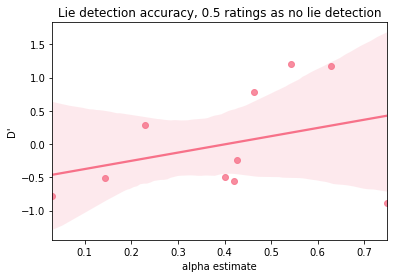

In [294]:
p = sns.regplot(s_ev_alpha, d_prime)
p.set(xlabel="alpha estimate", ylabel="D'")
p.set_title("Lie detection accuracy, 0.5 ratings as no lie detection")

C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Lie detection accuracy, 0.5 ratings as no lie detection')

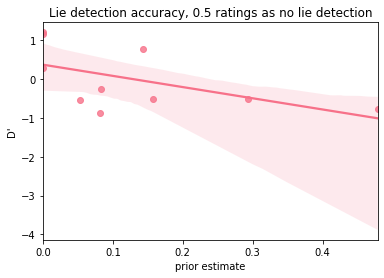

In [295]:
p = sns.regplot(s_ev_prior, d_prime)
p.set(xlabel="prior estimate", ylabel="D'")
p.set_title("Lie detection accuracy, 0.5 ratings as no lie detection")

C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, "Lie detection accuracy including 'neutral' ratings as lie detection")

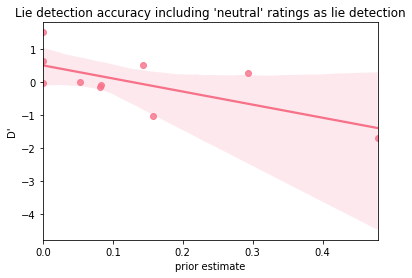

In [303]:
p = sns.regplot(s_ev_prior, d_prime)
p.set(xlabel="prior estimate", ylabel="D'")
p.set_title("Lie detection accuracy including 'neutral' ratings as lie detection")

In [304]:
pearsonr(s_ev_prior, d_prime)

(-0.6874627892215447, 0.02803528957174304)

In [306]:
pearsonr(lie_prop, d_prime)

(-0.08206081515756322, 0.8216958936777368)

In [312]:
# excluding 0.5 rating
pearsonr(lie_prop, d_prime)

(0.20942025988413543, 0.5614611420011463)

In [200]:
rt_lie = [3606,
8980.275,
3427.293,
2479.047,
2390.938,
2375.609,
2420.222,
4083.833,
2616.194,
2176.9]

rt_nolie = [
    3204.079,
3019.02,
3120.204,
2223.83,
4817.405,
2472.343,
2318.667,
3502.714,
2756.13,
1987.286]

Text(0.5, 1.0, 'SAME subjects seem slower at rating honesty after they lied themselves')

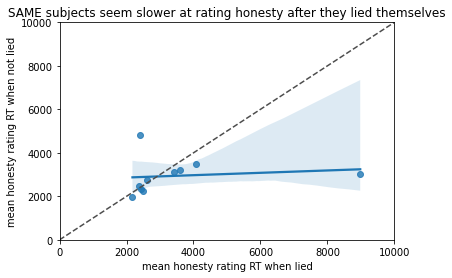

In [214]:
p = sns.regplot(x=rt_lie, y=rt_nolie)
p.set(xlim=(0,10000), ylim=(0,10000), xlabel="mean honesty rating RT when lied", ylabel="mean honesty rating RT when not lied")
p.plot(p.get_xlim(), p.get_ylim(), ls="--", c=".3")
p.set_title("SAME subjects seem slower at rating honesty after they lied themselves")

In [221]:
s_ev_alpha = [0.426,
0.42,
0.143,
0.463,
0.749,
0.4,
0.628,
0.229,
0.031,
0.543]

In [222]:
s_ev_prior = [0.083,
0.053,
0.158,
0.143,
0.082,
0.294,
0,
0,
0.479,
0]

In [223]:
lie_prop = []
for uuid in uuids:
    lie_prop.append(sum(when_lied[uuid])/len(when_lied[uuid]))

In [224]:
from statistics import median

In [225]:
median(s_ev_alpha)

0.423

In [346]:
median(lie_prop)

0.3277777777777778

In [345]:
lie_prop

[0.011111111111111112,
 0.4444444444444444,
 0.45555555555555555,
 0.4777777777777778,
 0.17777777777777778,
 0.25555555555555554,
 0.6,
 0.06666666666666667,
 0.4,
 0.2222222222222222]

In [226]:
s_ev_alpha_hmedian = [1 if v > median(s_ev_alpha) else 0 for v in s_ev_alpha]

In [227]:
s_ev_prior_hmedian = [1 if v > median(s_ev_prior) else 0 for v in s_ev_prior]

In [228]:
s_ev_alpha_hmedian

[1, 0, 0, 1, 1, 0, 1, 0, 0, 1]

In [229]:
hrs = []
for uuid in uuids:
    r = [ratings[uuid][k] for k in ratings[uuid].keys()]
    hrs.append(sum(r)/len(r))

In [230]:
hrs

[0.3333333333388889,
 0.30000000000444443,
 0.24259259260333327,
 0.4148148148155553,
 0.5222222222211108,
 0.5296296296322222,
 0.35925925926111113,
 0.11666666666333331,
 0.4962962963,
 0.2777777777833332]

In [321]:
tmp = pd.DataFrame({"higher_than_median": s_ev_alpha_hmedian, 
                    "s_ev_alpha": s_ev_alpha, 
                    "s_ev_prior": s_ev_prior, 
                    "s_ev_prior_hmedian": s_ev_prior_hmedian, 
                    "lie_prop": lie_prop,
                    "lied_more": [v > median(lie_prop) for v in lie_prop],
                   "mean_normed_suspicion_rating": hrs,
                   "subject": [i for i in range(len(hrs))]})

[Text(0, 0, 'lied < median'), Text(1, 0, 'lied > median')]

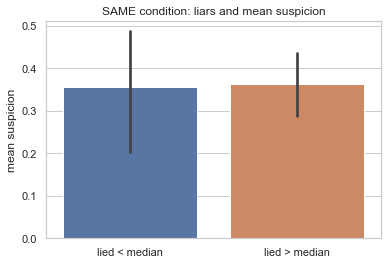

In [324]:
p = sns.barplot(data=tmp, x="lied_more", y="mean_normed_suspicion_rating")
p.set(xlabel="", ylabel="mean suspicion")
p.set_title("SAME condition: liars and mean suspicion")
p.set_xticklabels(["lied < median", "lied > median"])

[Text(0, 0, 'lied < median'), Text(1, 0, 'lied > median')]

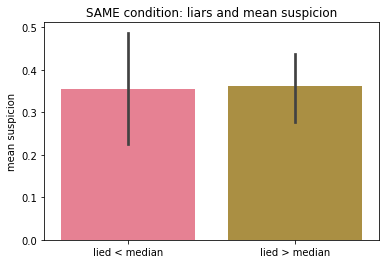

In [233]:
p = sns.barplot(data=tmp, x="lied_more", y="mean_normed_suspicion_rating")
p.set(xlabel="", ylabel="mean suspicion")
p.set_title("SAME condition: liars and mean suspicion")
p.set_xticklabels(["lied < median", "lied > median"])

Text(0.5, 1.0, 'SAME signed EV model w/o update rule: high vs low alpha and lie proportion')

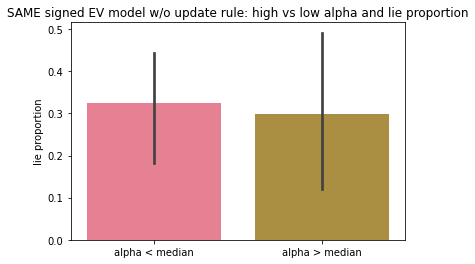

In [282]:
p = sns.barplot(data=tmp, y="lie_prop", x="higher_than_median")
p.set(xlabel="", ylabel="lie proportion")
p.set_xticklabels(['alpha < median', 'alpha > median'])
p.set_title("SAME signed EV model w/o update rule: high vs low alpha and lie proportion")

Text(0.5, 1.0, 'SAME condition signed EV model w/o update rule: high vs low prior and lying')

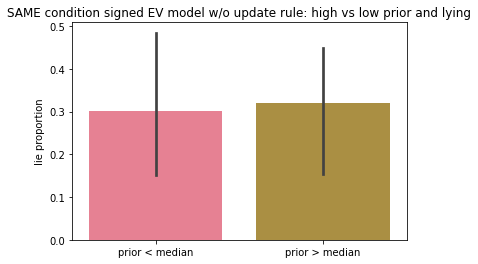

In [283]:
p = sns.barplot(data=tmp, y="lie_prop", x="s_ev_prior_hmedian")
p.set(xlabel="", ylabel="lie proportion")
p.set_xticklabels(['prior < median', 'prior > median'])
p.set_title("SAME condition signed EV model w/o update rule: high vs low prior and lying")

In [326]:
dfs['outcome_same_as_pick'] = dfs['outcome'] == dfs['picked_col']

Text(0.5, 1.0, "Suspicion when other player's reported colour was the same as the subject's random card pick or not")

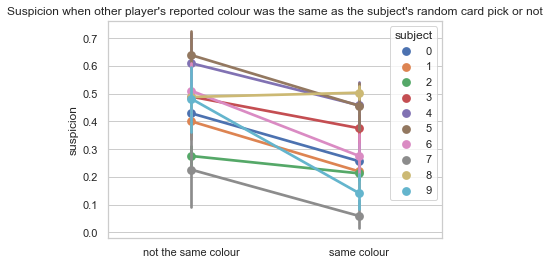

In [327]:
p = sns.pointplot(data=dfs, x="outcome_same_as_pick", y="hr", hue="subject")
p.set(xlabel="", ylabel="suspicion")
p.set_xticklabels(["not the same colour", "same colour"])
p.set_title("Suspicion when other player's reported colour was the same as the subject's random card pick or not")

In [328]:
from scipy.stats import mannwhitneyu

mannwhitneyu(dfs[dfs['outcome_same_as_pick'] == 1]['hr'], dfs[dfs['outcome_same_as_pick'] == 0]['hr'])

MannwhitneyuResult(statistic=68063.5, pvalue=8.770153267644722e-16)

C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


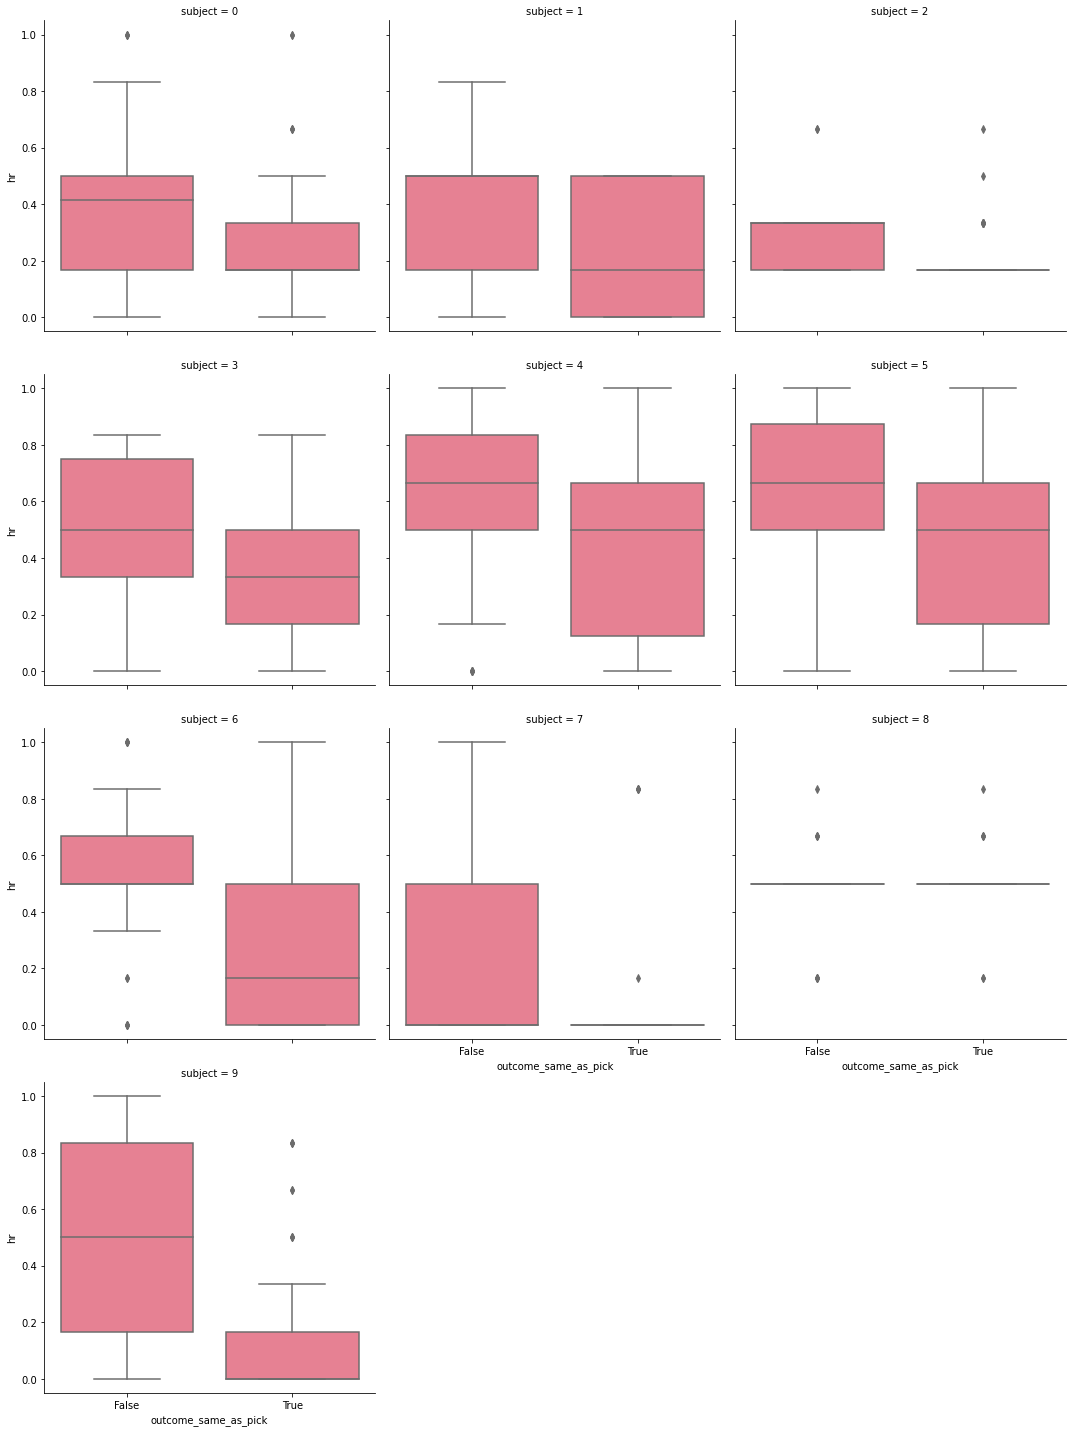

In [287]:
g = sns.FacetGrid(dfs, col="subject", col_wrap=3, height=5)
g.map(sns.boxplot, "outcome_same_as_pick", "hr")

In [152]:
from collections import Counter

Counter(dfs['tcond_transition'])

Counter({0.0: 160,
         8.0: 40,
         1.0: 62,
         -2.0: 50,
         2.0: 70,
         -11.0: 23,
         3.0: 34,
         5.0: 40,
         -8.0: 20,
         -6.0: 50,
         -1.0: 50,
         7.0: 50,
         -5.0: 20,
         -4.0: 30,
         -10.0: 20,
         9.0: 30,
         -12.0: 20,
         4.0: 50,
         -9.0: 31,
         10.0: 10,
         6.0: 10,
         11.0: 10,
         -3.0: 20})

In [153]:
Counter(dfs['nred_transition'])

Counter({0.0: 210,
         -4.0: 50,
         1.0: 115,
         -2.0: 80,
         2.0: 110,
         -3.0: 100,
         -1.0: 90,
         4.0: 80,
         3.0: 25,
         -5.0: 20,
         5.0: 20})

C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


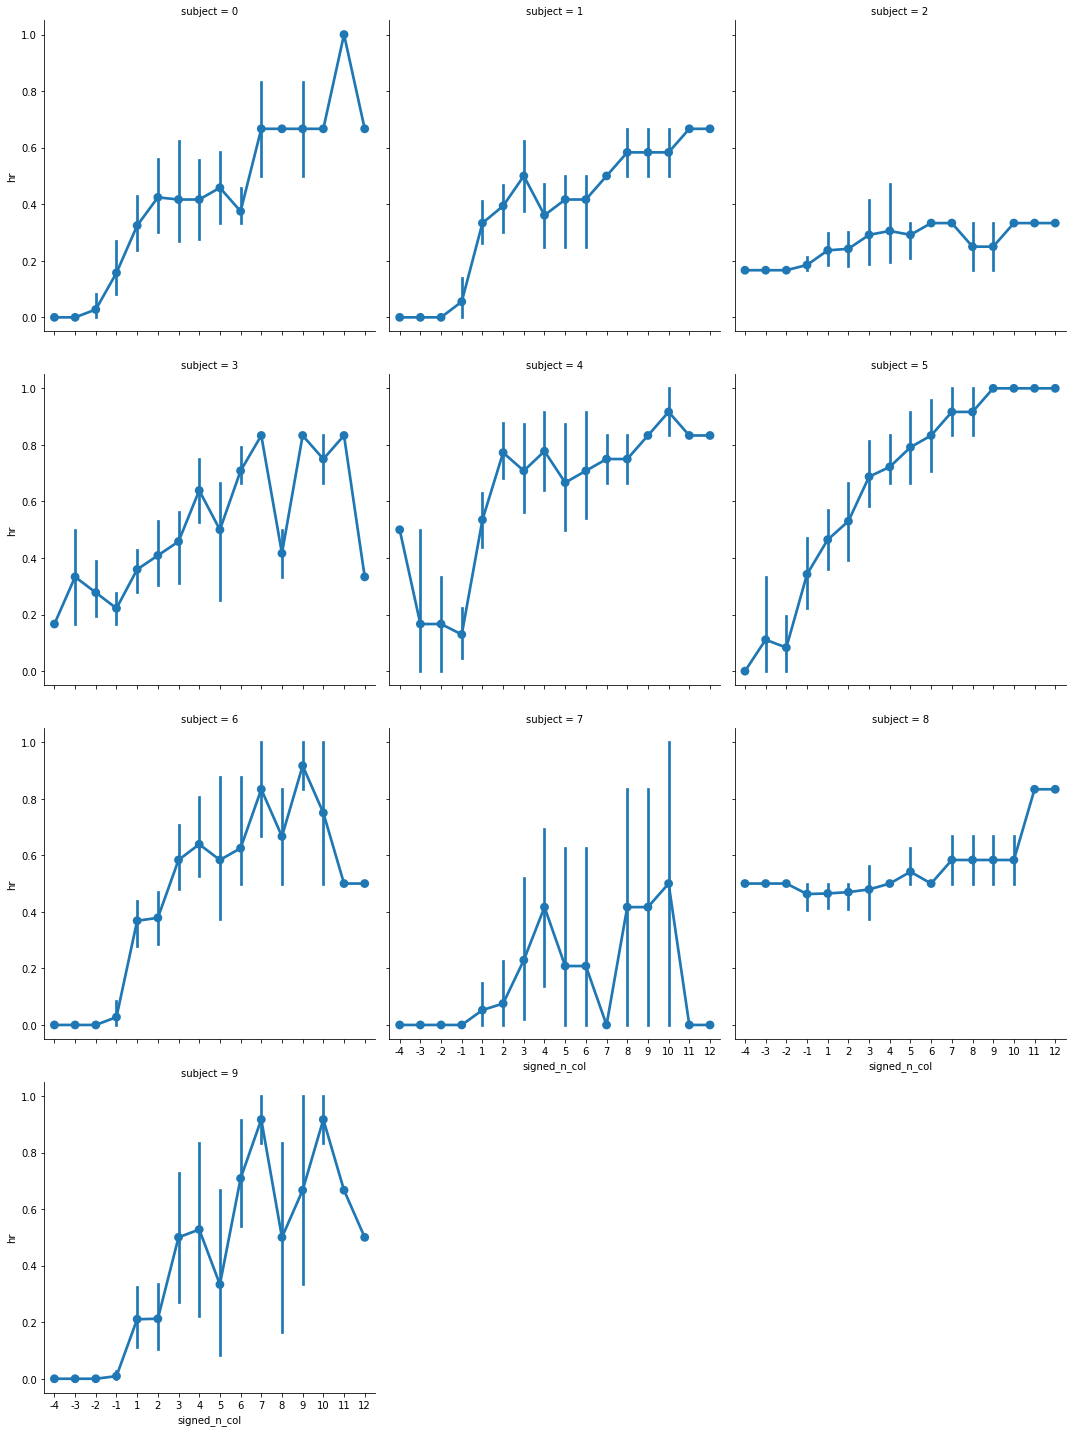

In [154]:
g = sns.FacetGrid(dfs, col="subject", col_wrap=3, height=5)
g.map(sns.pointplot, "signed_n_col", "hr")

C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


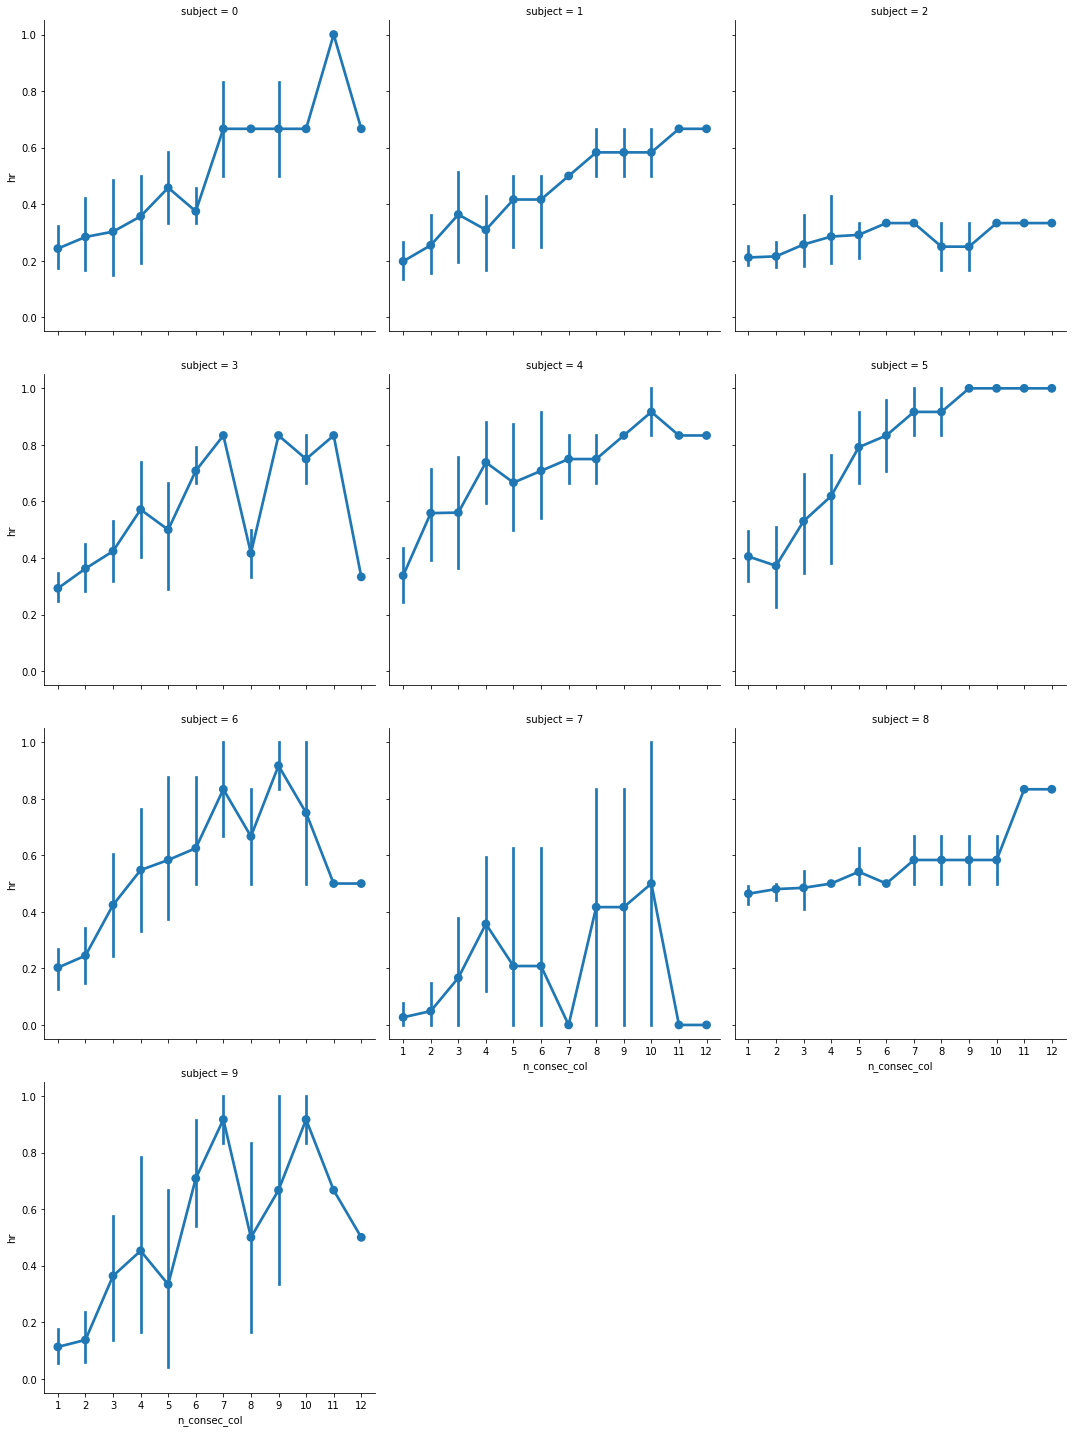

In [155]:
g = sns.FacetGrid(dfs, col="subject", col_wrap=3, height=5)
g.map(sns.pointplot, "n_consec_col", "hr")

C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


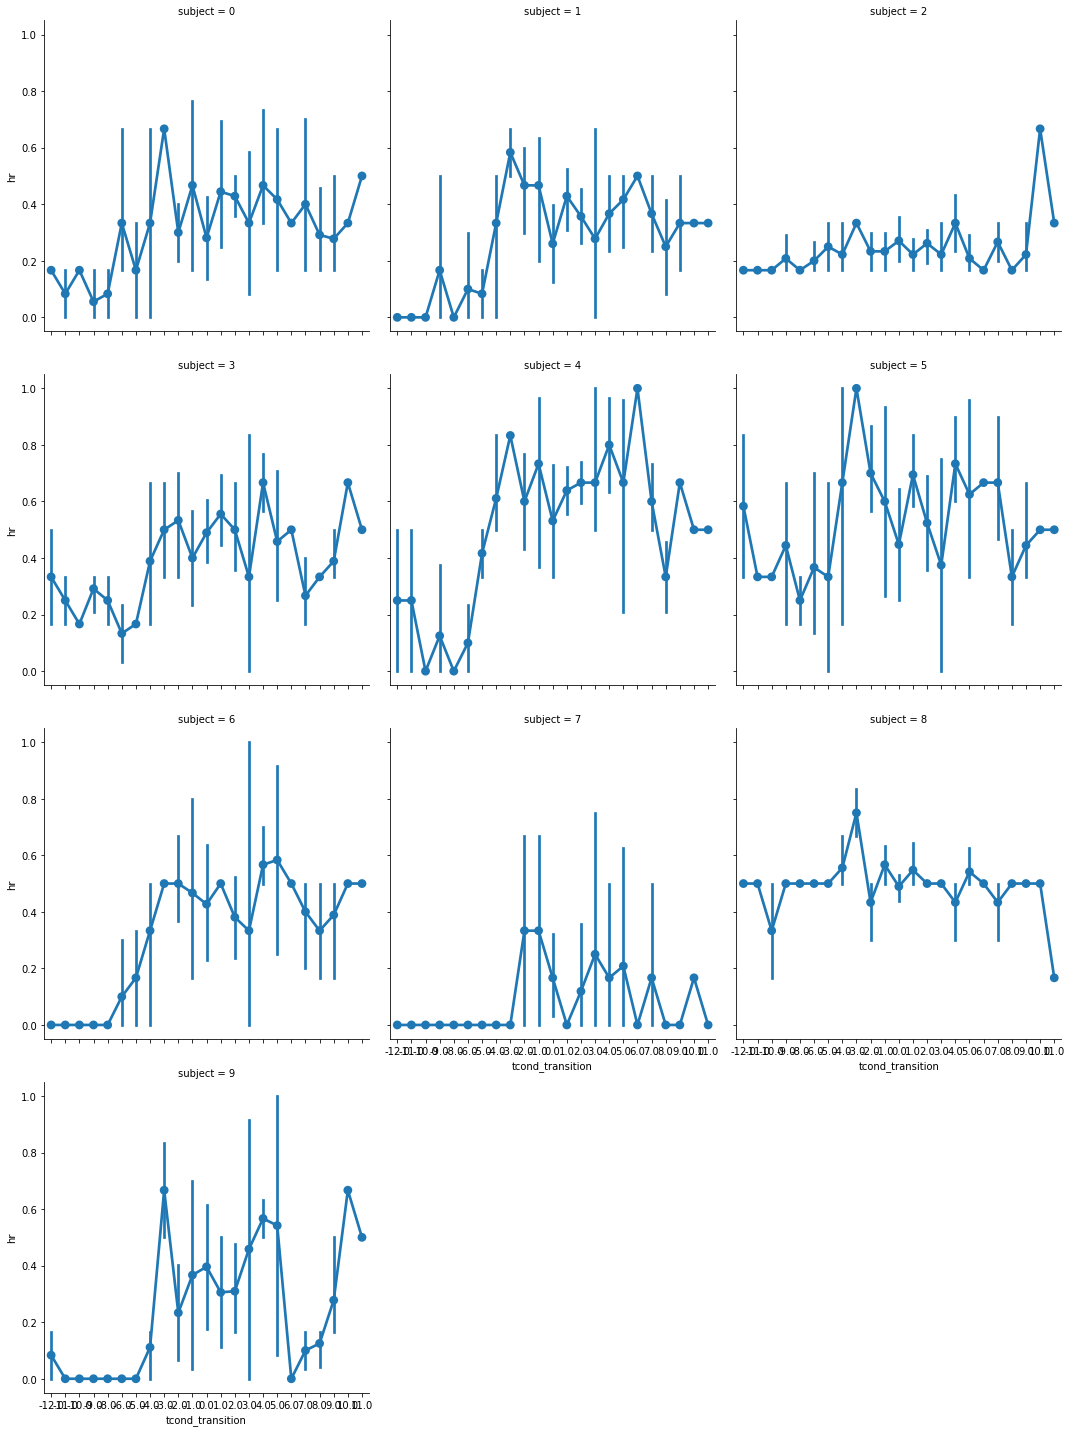

In [156]:
g = sns.FacetGrid(dfs, col="subject", col_wrap=3, height=5)
g.map(sns.pointplot, "tcond_transition", "hr")

C:\Users\Sarah Zheng\.conda\envs\sim-test\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


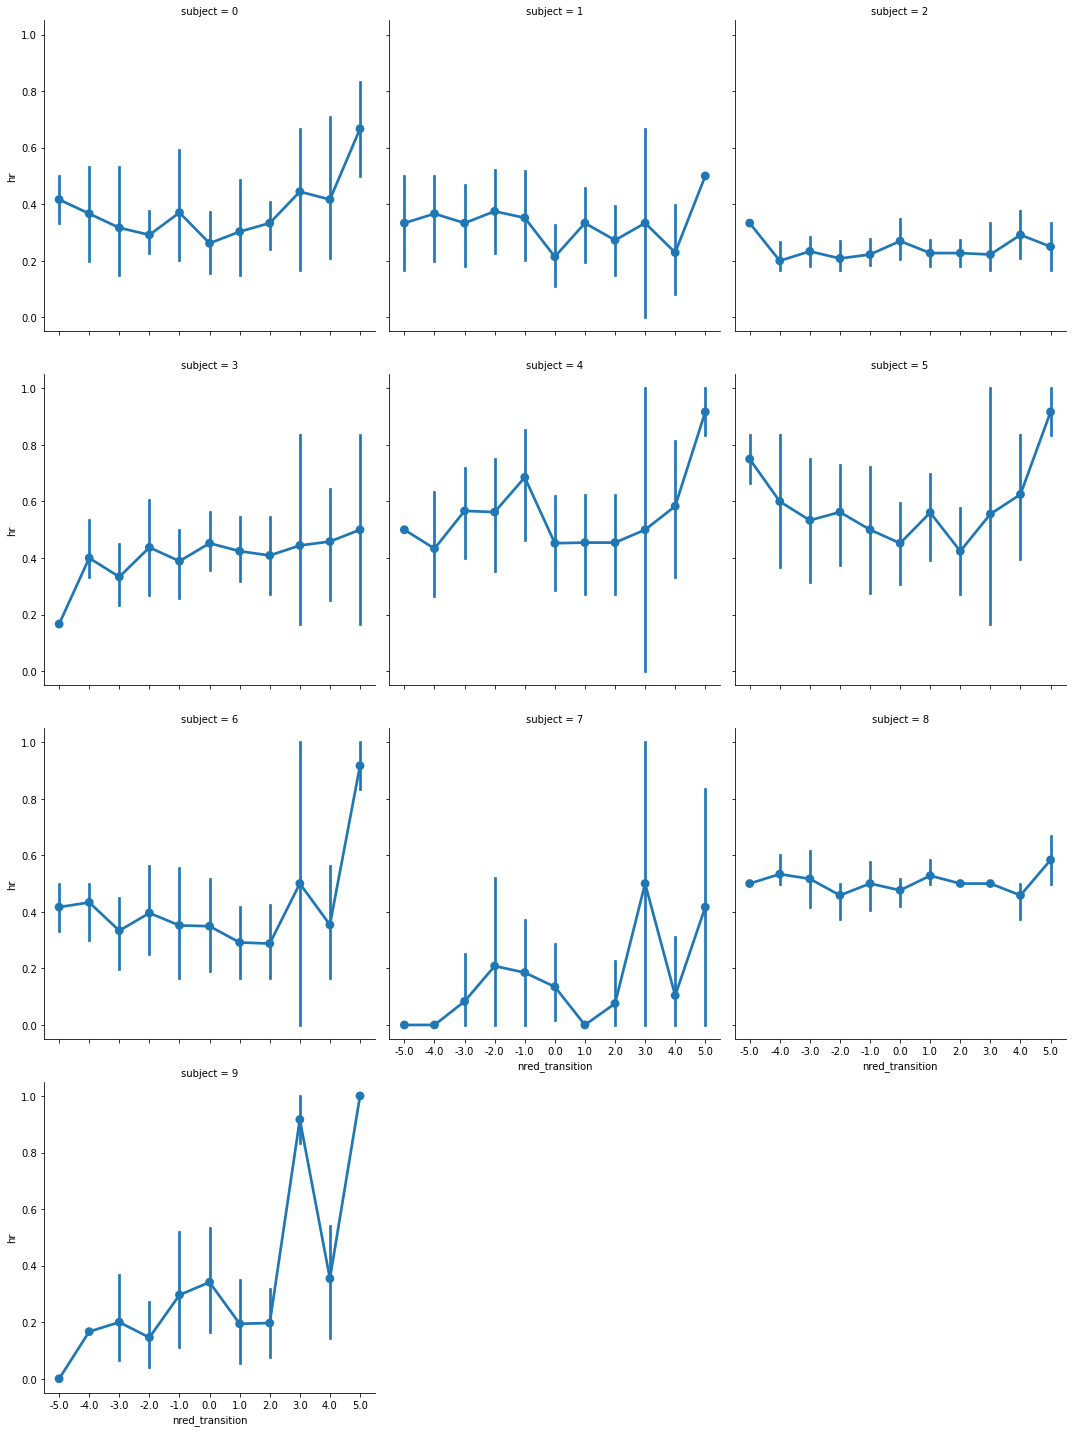

In [157]:
g = sns.FacetGrid(dfs, col="subject", col_wrap=3, height=5)
g.map(sns.pointplot, "nred_transition", "hr")

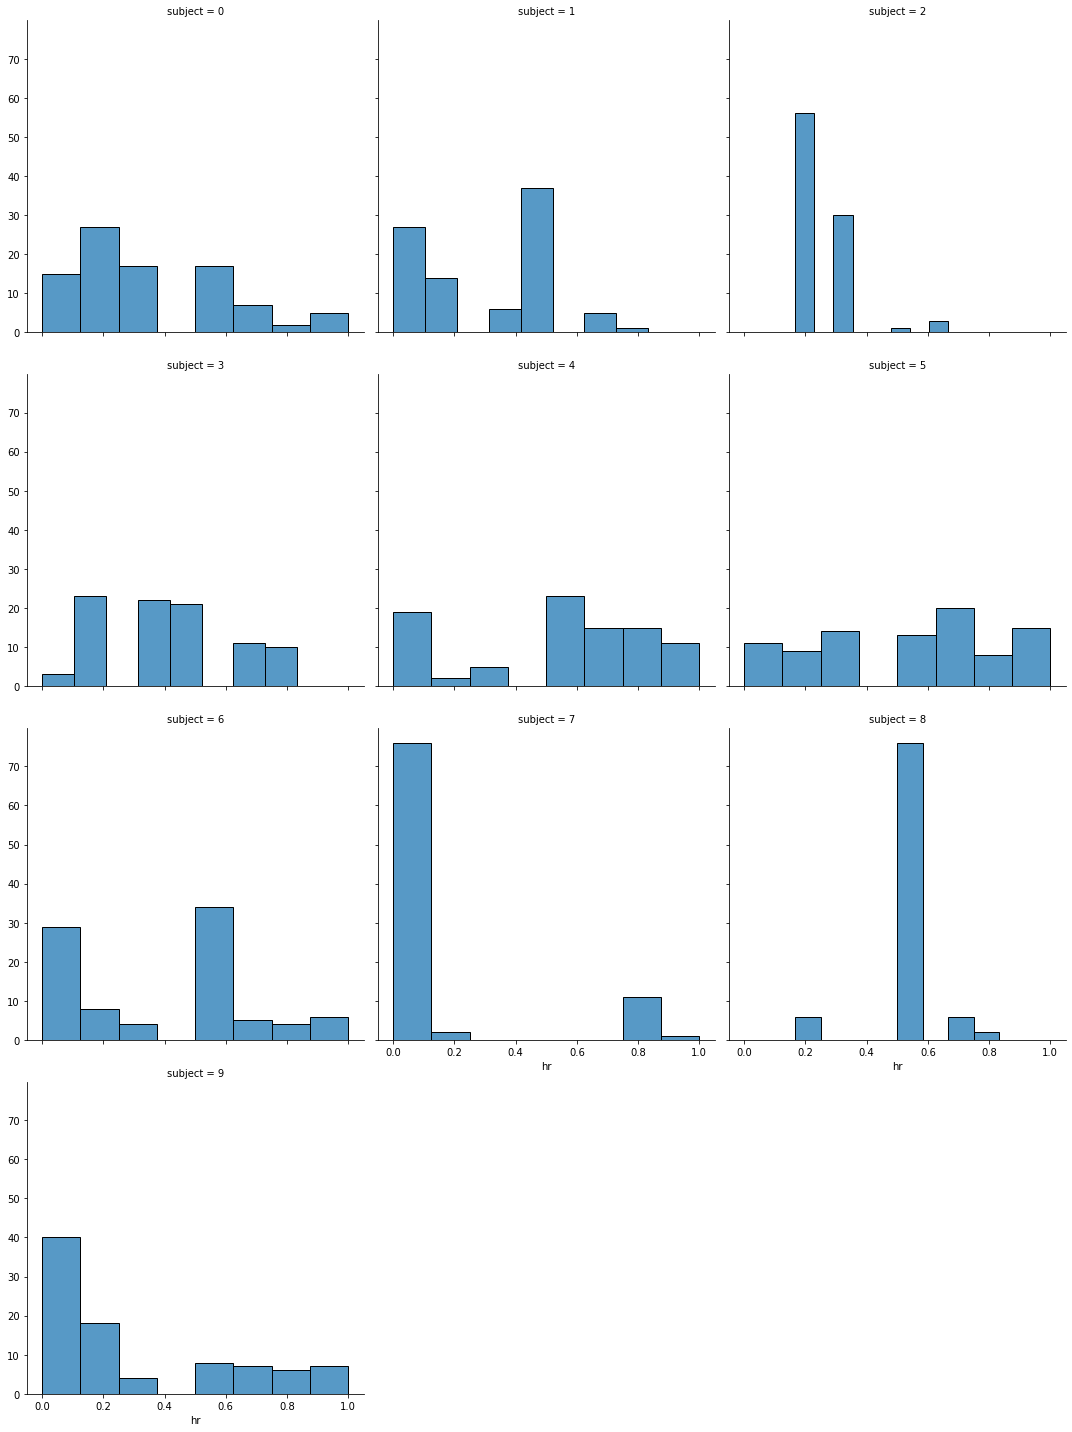

In [158]:
g = sns.FacetGrid(dfs, col="subject", col_wrap=3, height=5)
g.map(sns.histplot, "hr")

<AxesSubplot:xlabel='hr', ylabel='Count'>

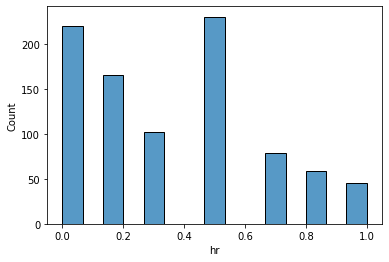

In [159]:
sns.histplot(data=dfs, x="hr")

# plot w/o subject 8

<AxesSubplot:xlabel='nred_transition', ylabel='hr'>

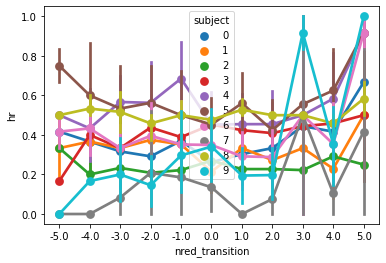

In [160]:
sns.pointplot(x="nred_transition", y="hr", hue="subject", data=dfs)

[Text(0.5, 0, 'signed trial condition change'), Text(0, 0.5, 'suspicion')]

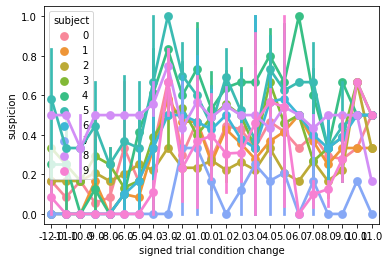

In [284]:
p = sns.pointplot(x="tcond_transition", y="hr", hue="subject", data=dfs)
p.set(xlabel="signed trial condition change", ylabel="suspicion")

[Text(0.5, 0, 'unsigned consecutive colours count'), Text(0, 0.5, 'suspicion')]

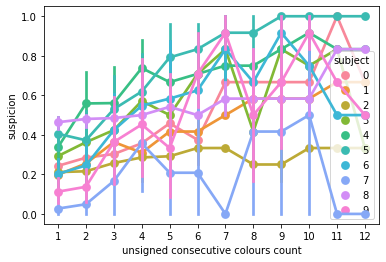

In [220]:
p = sns.pointplot(x="n_consec_col", y="hr", hue="subject", data=dfs)
p.set(xlabel="unsigned consecutive colours count", ylabel="suspicion")

[Text(0.5, 0, 'signed consecutive colours count'), Text(0, 0.5, 'suspicion')]

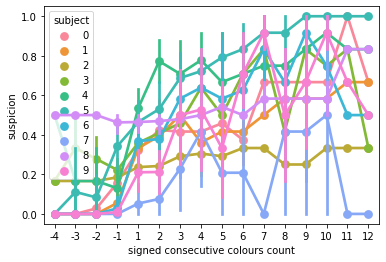

In [218]:
p = sns.pointplot(x="signed_n_col", y="hr", hue="subject", data=dfs)
p.set(xlabel="signed consecutive colours count", ylabel="suspicion")

Text(0.5, 1.0, 'Suspicion when subjects lied vs when they did not')

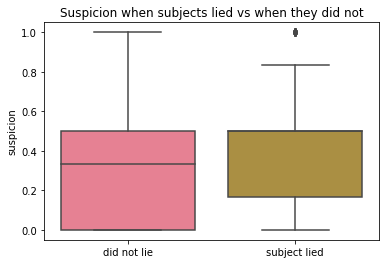

In [313]:
p = sns.boxplot(data=dfs, x="lied", y="hr")
p.set(xlabel="", ylabel="suspicion")
p.set_xticklabels(["did not lie", "subject lied"])
p.set_title("Suspicion when subjects lied vs when they did not")

Text(0.5, 1.0, 'Suspicion when subjects lied vs when they did not')

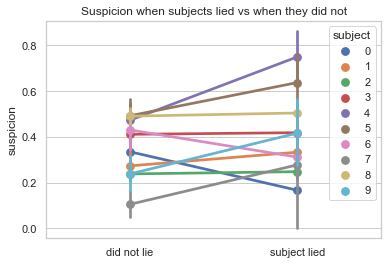

In [329]:
p = sns.pointplot(data=dfs, x="lied", y="hr", hue="subject")
p.set(xlabel="", ylabel="suspicion")
p.set_xticklabels(["did not lie", "subject lied"])
p.set_title("Suspicion when subjects lied vs when they did not")

In [330]:
mannwhitneyu(dfs[dfs['lied'] == 1]['hr'], dfs[dfs['lied'] == 0]['hr'])

MannwhitneyuResult(statistic=75406.0, pvalue=0.0006389975643670442)